## Setups

In [1]:
import datetime
import h5py
import jax.numpy as jnp
from jax import random
from jax.experimental import optimizers
from jax.config import config
from jax.nn import relu
from jax.random import poisson as jpoisson
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as np  # original CPU-backed NumPy
import scipy.signal
import scipy.stats
import os
import sys
import time
from importlib import reload
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import time
plt.rcParams.update({'font.size': 18})

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

start = time.time()

C:\Users\Ayoade (deb) Adeyemi\anaconda3\envs\DS_Tutorial\lib\site-packages\jax\experimental\optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [2]:
data1 = h5py.File("lfads_emg_data.h5", 'r')

Keys: <KeysViewHDF5 ['train_data', 'train_decode', 'train_inds', 'valid_data', 'valid_decode', 'valid_inds']>


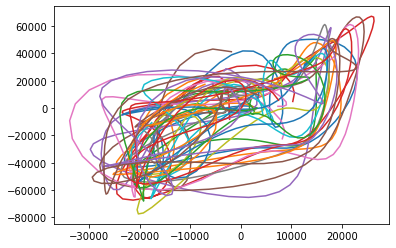

In [3]:
#data1.keys()
print("Keys: %s" % data1.keys())
data1['train_decode'].shape
for x in range(0,data1['train_decode'].shape[0],10):
    plt.plot(data1['train_decode'][x,:,1],data1['train_decode'][x,:,2])
    
    
#np.unique(data1['train_inds'])
#plt.hist(data1['train_data'][...,0])

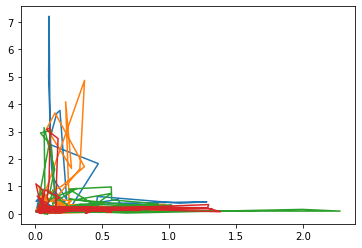

In [4]:
for x in range(0,data1['valid_data'].shape[0],10):
    plt.plot(data1['valid_data'][x,:,1],data1['valid_data'][x,:,2])
    
    
#np.unique(data1['train_inds'])
#plt.hist(data1['train_data'][...,0])

In [5]:
eval_data = data1['valid_data']

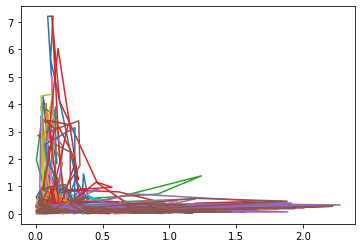

In [6]:
for x in range(0,data1['train_data'].shape[0],10):
    plt.plot(data1['train_data'][x,:,1],data1['train_data'][x,:,2])

In [7]:
data2 = np.log(data1['train_data'])

In [8]:
# You must change this to the location of the computation-thru-dynamics directory.
HOME_DIR = '' 

sys.path.append(os.path.join(HOME_DIR,'jax-lfads'))

import lfads_tutorial.lfads as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun
from lfads_tutorial.lfads import sigmoid

import matplotlib.pyplot as plt
import pandas as pd
#from nlb_tools.nwb_interface import NWBDataset


In [31]:
# Make directories
lfads_dir = ''       # where to save lfads data and parameters to
output_dir = os.path.join(lfads_dir, 'output/')
figure_dir = os.path.join(lfads_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(lfads_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

In [10]:
data_bxtxn = data2
data_bxtxn.shape

(151, 112, 12)

In [11]:
data_dt = 10.0        # define our dt in a physiological range [ms]

train_fraction = 0.9      # Train with 90% of the synthetic data

nexamples, ntimesteps, data_dim = data_bxtxn.shape

# train_data, eval_data = utils.split_data(data_bxtxn,
#                                          train_fraction=train_fraction)
# eval_data_offset = int(train_fraction * data_bxtxn.shape[0])

# # # find reach directions for labeling
# # conds = dataset.trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()
# # # Loop over conditions and compute average trajectory
# # reach_angle = np.empty(len(dataset.trial_info)).astype('float32')
# # for cond in conds:
# #     # Find trials in condition
# #     mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
# #     # Determine reach angle for color
# #     active_target = dataset.trial_info[mask].target_pos.iloc[0][dataset.trial_info[mask].active_target.iloc[0]]
# #     reach_angle[mask] = np.arctan2(*active_target[::-1])

In [12]:
eval_data = np.log(data1['valid_data'])
eval_data.shape

(38, 112, 12)

In [13]:
import sklearn
ncomponents = data_dim
full_pca = sklearn.decomposition.PCA(ncomponents)
full_pca.fit(np.reshape(data_bxtxn, [-1, data_dim]))

PCA(n_components=12)

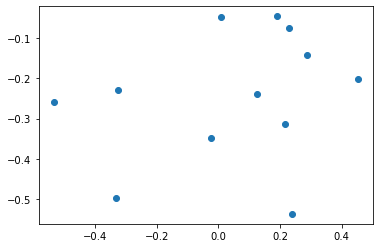

In [14]:
plt.scatter(*full_pca.components_[:2])

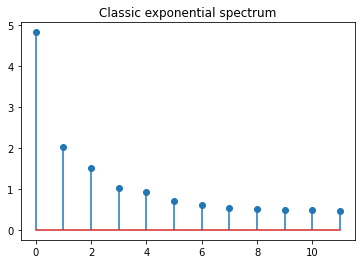

In [15]:
plt.stem(full_pca.explained_variance_)
plt.title('Classic exponential spectrum');

### Set LFADS Parameters

In [16]:
# LFADS Hyper parameters
data_dim = data2.shape[2]  # input to lfads should have dimensions:
ntimesteps = data2.shape[1] #   (batch_size x ntimesteps x data_dim)
batch_size = 100      # batch size during optimization

# LFADS architecture - The size of the numbers is rather arbitrary, 
# but relatively small because we know the integrator RNN isn't too high 
# dimensional in its activity.
enc_dim = 64         # encoder dim
con_dim = 0          # controller dim
ii_dim = 0           # inferred input dim
gen_dim = 64         # generator dim, should be large enough to generate integrator RNN dynamics
factors_dim = 8      # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
var_min = 0.001 # Minimal variance any gaussian can become.

# Optimization HPs that percolates into model
l2reg = 0.00002

# Initial state prior parameters
# the mean is set to zero in the code
ic_prior_var = 0.1 # this is $\sigma^2_p$ in above paragraph

# Inferred input autoregressive prior parameters
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

lfads_hps = {'data_dim' : data_dim, 'ntimesteps' : ntimesteps,
             'enc_dim' : enc_dim, 'con_dim' : con_dim, 'var_min' : var_min,
             'ic_prior_var' : ic_prior_var, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : ii_dim, 'gen_dim' : gen_dim,
             'factors_dim' : factors_dim,
             'l2reg' : l2reg,
             'batch_size' : batch_size}

num_batches = 20000         # how many batches do we train
print_every = 100            # give information every so often

# Learning rate HPs
step_size = 0.01            # initial learning rate
decay_factor = 0.9998       # learning rate decay param
decay_steps = 1             # learning rate decay param

# Regularization HPs
keep_rate = 0.95             # dropout keep rate during training

# Numerical stability HPs
max_grad_norm = 10.0        # gradient clipping above this value

# The fact that the start and end values are required to be floats is something I need to fix.
kl_warmup_start = 0.0 # batch number to start KL warm-up, explicitly float
kl_warmup_end = 1000.0  # batch number to be finished with KL warm-up, explicitly float
kl_min = 0.001 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : step_size,
                 'decay_steps' : decay_steps, 'decay_factor' : decay_factor,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : max_grad_norm, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-4}

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))

lfads_hps = hashabledict(lfads_hps)
lfads_opt_hps = hashabledict(lfads_opt_hps)

assert num_batches >= print_every and num_batches % print_every == 0

### Initialize LFADS

In [17]:
# Initialize parameters for LFADS
from functools import partial

rnn_type = 'gru'
if rnn_type=='vrnn':
  nonlin = lambda x: jnp.tanh(x)
  model = partial(vanilla_rnn, **{'nonlin': nonlin})
  model_params = vanilla_rnn_params
elif rnn_type=='vrnn_relu':
  nonlin = lambda x: relu(x)
  model = partial(vanilla_rnn, **{'nonlin': nonlin})
  model_params = vanilla_rnn_params
elif rnn_type=='gru':
  # to get the results like in Nature Methods
  model = lfads.gru
  model_params = lfads.gru_params
else:
  raise ValueError('Unknown type')
  
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
init_params = lfads.lfads_params(key, lfads_hps, gen_rnn_params=model_params)

### Option 1: Train LFADS

In [18]:
# Takes 12 minutes to train on a GPU; first step takes ~20 sec.
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,\
                   data2, eval_data, gen=model)

Batches 1-100 in 343.41 sec, Step size: 0.00980
    Training losses 2648 = NLL 2648 + KL IC 8,0 + KL II 0,0 + L2 0.03
        Eval losses 2650 = NLL 2650 + KL IC 9,0 + KL II 0,0 + L2 0.03
Batches 101-200 in 128.80 sec, Step size: 0.00961
    Training losses 2644 = NLL 2644 + KL IC 3,0 + KL II 0,0 + L2 0.03
        Eval losses 2641 = NLL 2641 + KL IC 3,0 + KL II 0,0 + L2 0.03
Batches 201-300 in 121.77 sec, Step size: 0.00942
    Training losses 2643 = NLL 2642 + KL IC 1,0 + KL II 0,0 + L2 0.04
        Eval losses 2642 = NLL 2642 + KL IC 1,0 + KL II 0,0 + L2 0.04
Batches 301-400 in 124.10 sec, Step size: 0.00923
    Training losses 2642 = NLL 2641 + KL IC 1,0 + KL II 0,0 + L2 0.04
        Eval losses 2643 = NLL 2643 + KL IC 1,0 + KL II 0,0 + L2 0.04
Batches 401-500 in 121.79 sec, Step size: 0.00905
    Training losses 2645 = NLL 2645 + KL IC 1,0 + KL II 0,0 + L2 0.04
        Eval losses 2644 = NLL 2644 + KL IC 1,0 + KL II 0,0 + L2 0.04
Batches 501-600 in 120.58 sec, Step size: 0.00887
  

Batches 4301-4400 in 125.49 sec, Step size: 0.00415
    Training losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 4401-4500 in 103.89 sec, Step size: 0.00407
    Training losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 4501-4600 in 70.87 sec, Step size: 0.00398
    Training losses 2641 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 4601-4700 in 77.04 sec, Step size: 0.00391
    Training losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2642 = NLL 2642 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 4701-4800 in 88.86 sec, Step size: 0.00383
    Training losses 2642 = NLL 2642 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 4801-4900 in 89.32 sec, Step size: 

Batches 8601-8700 in 133.31 sec, Step size: 0.00175
    Training losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 8701-8800 in 127.15 sec, Step size: 0.00172
    Training losses 2642 = NLL 2642 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2642 = NLL 2642 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 8801-8900 in 129.34 sec, Step size: 0.00169
    Training losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 8901-9000 in 130.45 sec, Step size: 0.00165
    Training losses 2639 = NLL 2639 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 9001-9100 in 129.19 sec, Step size: 0.00162
    Training losses 2643 = NLL 2642 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2643 = NLL 2643 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 9101-9200 in 131.42 sec, Step si

Batches 12901-13000 in 123.58 sec, Step size: 0.00074
    Training losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 13001-13100 in 128.91 sec, Step size: 0.00073
    Training losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 13101-13200 in 132.18 sec, Step size: 0.00071
    Training losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2639 = NLL 2639 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 13201-13300 in 130.61 sec, Step size: 0.00070
    Training losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 13301-13400 in 131.43 sec, Step size: 0.00069
    Training losses 2643 = NLL 2643 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2644 = NLL 2644 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 13401-13500 in 128.08 

Batches 17201-17300 in 120.44 sec, Step size: 0.00031
    Training losses 2639 = NLL 2639 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 17301-17400 in 127.70 sec, Step size: 0.00031
    Training losses 2642 = NLL 2642 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2639 = NLL 2638 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 17401-17500 in 127.31 sec, Step size: 0.00030
    Training losses 2639 = NLL 2639 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 17501-17600 in 124.01 sec, Step size: 0.00030
    Training losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2640 = NLL 2640 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 17601-17700 in 125.51 sec, Step size: 0.00029
    Training losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
        Eval losses 2641 = NLL 2641 + KL IC 0,0 + KL II 0,0 + L2 0.07
Batches 17701-17800 in 118.08 

In [32]:
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = (f'trained_params_lfads_pend_{rnn_type}' + fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

print("Saving parameters: ", network_path)
np.savez(network_path, trained_params)


Saving parameters:  output/trained_params_lfads_pend_gru2022-09-01_22:11:02.npz


OSError: [Errno 22] Invalid argument: 'output/trained_params_lfads_pend_gru2022-09-01_22:11:02.npz'

In [ ]:
# Plot the training details
x = np.arange(0, num_batches, print_every)
plt.figure(figsize=(20,6))
plt.subplot(251)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(252)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(253)
plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
plt.title('KL inferred inputs')
plt.subplot(254)
plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
plt.title('KL initial state')
plt.subplot(255)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(256)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(257)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(258)
plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
plt.xlabel('Training batch')
plt.subplot(259)
plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
plt.xlabel('Training batch');

In [ ]:
# See the effect of the KL warmup, which is shown 
# by the KL penalities without the warmup scaling. 
plt.figure(figsize=(7,4))
plt.subplot(221)
plt.plot(x, opt_details['tlosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Training')
plt.subplot(222)
plt.plot(x, opt_details['tlosses']['kl_g0_prescale'], 'g--')
plt.subplot(223)
plt.plot(x, opt_details['elosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Evaluation')
plt.xlabel('Training batch')
plt.subplot(224)
plt.plot(x, opt_details['elosses']['kl_g0_prescale'], 'g--')
plt.xlabel('Training batch');

### Option 2: Load pre-trained model from file

In [ ]:
# # After training, you can load these up, after locating the save file.
# # network_fname = 'trained_params_lfads_128_vrnn2022-08-05_14:02:03.npz'
# network_fname = 'trained_params_lfads_128_gru2022-08-05_12:54:43.npz'
# network_path = os.path.join(output_dir, network_fname)

# loaded_params = np.load(network_path, allow_pickle=True)
# trained_params = loaded_params['arr_0'].item()


## Visualize latent space trajectories

In [ ]:
# Plot a bunch of examples of eval trials run through LFADS.
reload(plotting)
#reload(lfads)

def plot_rescale_fun(a): 
    fac = max_firing_rate * data_dt
    return renormed_fun(a) * fac


bidx = 0

nexamples_to_save = 1
for eidx in range(nexamples_to_save):
    fkey = random.fold_in(key, eidx)
    psa_example = eval_data[bidx,:,:].astype(jnp.float32)
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)

    # The inferred input and true input are rescaled and shifted via 
    # linear regression to match, as there is an identifiability issue. there.
    # plotting.plot_lfads(psa_example, psa_dict,
    #                     data_dict, eval_data_offset+bidx, plot_rescale_fun)


In [ ]:
# plt.plot(psa_dict['factor_t'])
plt.plot(psa_dict['factor_t'])
psa_dict.keys()

In [ ]:
# sample trajectories
ics = np.empty((data_bxtxn.shape[0],gen_dim))
gen_traj = np.empty((data_bxtxn.shape[0],ntimesteps,gen_dim))
for i, psa_example in enumerate(data_bxtxn.astype(jnp.float32)):
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)
    ics[i] = psa_dict['ic_mean']
    gen_traj[i] = psa_dict['gen_t']

In [ ]:
ics.shape

In [ ]:
ncomponents = 3
pca = PCA(ncomponents)
pca.fit(np.reshape(gen_traj, [-1, gen_dim]))

S = pca.components_.T

for a,t in zip(reach_angle,gen_traj):
  plt.plot(*(t@S)[:,[1,2]].T, c=plt.cm.rainbow(a / (2*np.pi) + 0.5),alpha=0.5)



In [ ]:


# print((gen_traj@S)[:,0])

df = pd.DataFrame.from_dict({'PC0': (gen_traj@S)[::10,:,0].flatten(),
                             'PC1': (gen_traj@S)[::10,:,1].flatten(),
                             'PC2': (gen_traj@S)[::10,:,2].flatten(),
                             'color': reach_angle[::10].repeat(ntimesteps).T})

fig = px.scatter_3d(df, x="PC0", y="PC1", z="PC2",color='color')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=.01,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [ ]:
from sklearn.manifold import TSNE

ncomponents = 3
tsne = TSNE(ncomponents)#,perplexity=20)
embedded_ics = tsne.fit_transform(ics)

plt.scatter(*embedded_ics[:,:2].T, c=plt.cm.rainbow(reach_angle[:] / (2*np.pi) + 0.5),alpha=0.5)

## Fixed point analysis

In [ ]:
%load_ext autoreload
%autoreload 2
import fixed_point_finder.fixed_points as fp_optimize
from jax import vmap
import gc

gc.collect() # free up some RAM

In [ ]:
# These are some preliminaries. 
x_star = np.zeros(ii_dim)  # We always linearize the input around zero in this example.

# Make a one parameter function of thie hidden state, useful for jacobians.
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
rnn_fun = lambda h : model(trained_params['gen'], h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))


#### Create some functions that define the fixed point loss
which is just the squared error of a point  for a discrete time system such as a VRNN or GRU.

In [ ]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

We have to start the fixed point finder with some points, and it's usually ok to start with examples of where the state normally operates.... but not here ;) Here I 'helped' the model to find the fixed point that I'm interested in by starting closer to 0.


In [ ]:
fp_candidates = jnp.array(gen_traj[::50,])                        # was batch x time x dim
fp_candidates = jnp.reshape(fp_candidates/10, (-1, gen_dim))      # now (batch * time) x dim

In [ ]:
# Fixed point optimization hyperparameters
fp_num_batches = 1000         # Total number of batches to train on.
fp_batch_size = 100          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.25      # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.


In [ ]:
fp_candidates.shape

In [ ]:
reload(fp_optimize)

fp_tols = [0.0001, 0.00002] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
  fp_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
            'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
            'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2,
            'adam_eps' : fp_adam_eps, 'noise_var' : fp_noise_var, 
            'fp_opt_stop_tol' : tol, 'fp_tol' : tol, 
            'unique_tol' : fp_unique_tol, 'outlier_tol' : fp_outlier_tol, 
            'opt_print_every' : fp_opt_print_every}

  fp_hps = hashabledict(fp_hps)

  fps, fp_losses, fp_idxs, fp_opt_details = \
    fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
  if len(fp_idxs) > 0:
      F_of_fps = batch_rnn_fun(fps)
  else:
      F_of_fps = np.zeros([0,gen_dim])
      
  all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                  'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                  'opt_details' : fp_opt_details, 'hps' : fp_hps}

  all_fps[tol]


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# print((gen_traj@S)[:,0])

df = pd.DataFrame.from_dict({'PC0': (gen_traj@S)[::10,:,0].flatten(),
                             'PC1': (gen_traj@S)[::10,:,1].flatten(),
                             'PC2': (gen_traj@S)[::10,:,2].flatten(),
                             'color': reach_angle[::10].repeat(ntimesteps).T})

fig = px.scatter_3d(df, x="PC0", y="PC1", z="PC2",color='color')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=.01,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fixed_points = all_fps[0.00002]['fps'] @ S
print(fixed_points.shape)

fig.add_trace(
    go.Scatter3d(x=fixed_points[:,0],
                 y=fixed_points[:,1],
                 z=fixed_points[:,2],
                 mode='markers')
)
fig.show()


### Exercise 4: Linearizing around the fixed point: calculating the Jacobian

In [ ]:
jacs = fp_optimize.compute_jacobians(rnn_fun, all_fps[0.0001]['fps'])
i=0 # choose a fixed point
J = np.array(jacs[i]) # getting the jacobian for i-th fixed point
eig_decomps = np.linalg.eig(J) # calculating eigenvalues

In [ ]:
plt.figure(figsize=(4,4))
eigvals = eig_decomps[0]#['evals']
plt.scatter(eigvals.real, eigvals.imag)
x = jnp.linspace(-jnp.pi,jnp.pi,100)
plt.plot(jnp.sin(x),jnp.cos(x),c='k')
# plt.plot(x,jnp.cos(x))
# scale = np.sqrt(eigvals.real**2 + eigvals.imag**2).max()*1.05
scale=1
plt.xlim([-scale,+scale])
plt.ylim([-scale,+scale])
plt.xlabel('Re')
plt.ylabel('Im')

In [ ]:
end = time.time()

(end-start)/60

## References
<a name="references"></a>
0. [Computation through dynamics tutorial](https://github.com/google-research/computation-thru-dynamics) from David Sussillo, which contains an implementation of LFADS that was adapted to this tutorial + extra material (in depth LFADS tutorial, inferring unobserved inputs, FORCE training)

1. *Manifold hypothesis:* Gallego, Juan A., et al. "Neural manifolds for the control of movement." Neuron 94.5 (2017): 978-984.

2. *A review of a population dynamics models:* Vyas, Saurabh, et al. "Computation through neural population dynamics." Annual Review of Neuroscience 43 (2020): 249. [Not paywalled pdf.](https://web.stanford.edu/~mgolub/publications/2020-Vyas-ARN.pdf)

3. *Our review on fully observed vs latent dynamical models*: Hurwitz, Cole, et al. [Building population models for large-scale neural recordings: Opportunities and pitfalls.](https://arxiv.org/pdf/2102.01807.pdf) Current Opinion in Neurobiology 70 (2021): 64-73.

4. *For better understanding of PCA:* [Dimensionality reduction tutorial](https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/chapter_title.html) by Alex Cayco Gajic at Neuromatch Academy

5. *The LFADS paper:* Pandarinath, Chethan, et al. [Inferring single-trial neural population dynamics using sequential auto-encoders.](https://www.nature.com/articles/s41592-018-0109-9) Nature methods 15.10 (2018): 805-815.

6. *Critical view on rotational dynamics* Lebedev, Mikhail A., et al. "Analysis of neuronal ensemble activity reveals the pitfalls and shortcomings of rotation dynamics." Scientific Reports 9.1 (2019): 1-14.
  
## Interesting recent papers for further reading

If you want to know what's going on in the field right now, you can check the following papers (a very biased selection from Nina ;) ):

1. Smith, Jimmy, Scott Linderman, and David Sussillo. [Reverse engineering recurrent neural networks with jacobian switching linear dynamical systems.](https://arxiv.org/pdf/2111.01256.pdf) Advances in Neural Information Processing Systems 34 (2021): 16700-16713.
2. 

# Project

Pick another dataset (e.g. MC_RTT) from a [Neural Latents Benchmark](https://neurallatents.github.io/datasets.html) project. Follow the pre-processing notebook (available of NLB website) in order to align the data. Following the methods you learned today, analyse trial-average responses with dimensionality reduction techniques. Train a single-trial dynamical model to the data and analyse the latent dynamics (you can use the code from this notebook). 

Do your results agree with the type of computation that the neurons were supposed to perform?